#### Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'none'
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

#### Load 1st stacking layer models and 2nd stacking layer model or metalearner

In [2]:
models = {}
for model in ['LR','RF','KNN','ET','XGB','LGBM','DT','AB']:
    models[model] = pickle.load(open('Data/model_layer1_'+model+'.dat','rb'))
metalearner = pickle.load(open('Data/model_layer2_metalearner.dat','rb'))

#### Load preprocessed data splits

*Note:* The data splits contain all preprocessing including normalization and one hot encoding.

In [3]:
train,validation,test = pickle.load(open('Data/data_splits.dat','rb'))
target = 'treatment'
features = list(train.columns)
features.remove(target)
x_test,y_test = test[features],test[target]

#### Feature importance

For studying the feature importance (at population level) we will compute the *AUC* in *test* split after randomly permuting all features (feature by feature leaving the rest of features as original data) several times with different seeds. Then, we will create a feature importance indicator using the standard deviation of all permutations' AUC for each feature. The higher standard deviation the more importance because it means that changing the feature values affect more to the predictions.

*Note*: We can get the feature importance indicators for the metalearner or 2nd stacking layer model, but also for the 1st stacking layer models.

In [4]:
features_to_permute = ['Age','anonymity','benefits','care_options','coworkers','family_history','Gender',
                       'leave','mental_health_consequence','mental_health_interview','mental_vs_physical',
                       'no_employees','obs_consequence','phys_health_consequence','phys_health_interview',
                       'remote_work','seek_help','self_employed','supervisor','tech_company',
                       'wellness_program','work_interfere']
AUCs = {}
seeds = np.arange(1,6)
for feature_to_permute in features_to_permute:
    AUCs[feature_to_permute] = pd.DataFrame(data=None,index=['seed_'+str(seed) for seed in seeds])
    features_to_permute_ohe = [feature for feature in x_test.columns if feature_to_permute in feature]
    for seed in seeds:
        x_test_permuted = x_test
        # Permutation of test split
        np.random.seed(seed)
        idx = np.random.permutation(x_test_permuted.index)
        x_test_permuted[features_to_permute_ohe] = x_test_permuted.loc[idx,features_to_permute_ohe].values
        # 1st stacking layer prediction
        for model in models.keys():
            test['prediction_'+model] = models[model].predict_proba(x_test_permuted)[:,1]
            [fpr_test,tpr_test,thr_test] = roc_curve(y_test,test['prediction_'+model])
            AUCs[feature_to_permute].loc['seed_'+str(seed),model] = auc(fpr_test,tpr_test)
        # 2nd stacking layer prediction
        columns_predictions = ['prediction_'+model for model in models.keys()]
        x_test_permuted = test[columns_predictions]
        [fpr_test,tpr_test,thr_test] = roc_curve(y_test,metalearner.predict_proba(x_test_permuted)[:,1])
        AUCs[feature_to_permute].loc['seed_'+str(seed),'Metalearner'] = auc(fpr_test,tpr_test)

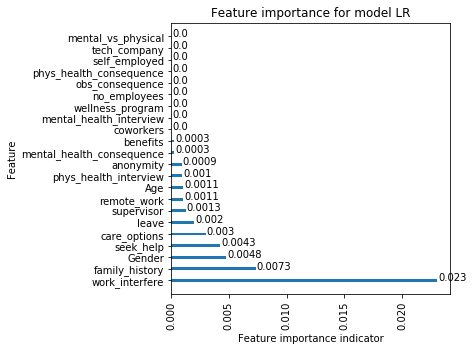

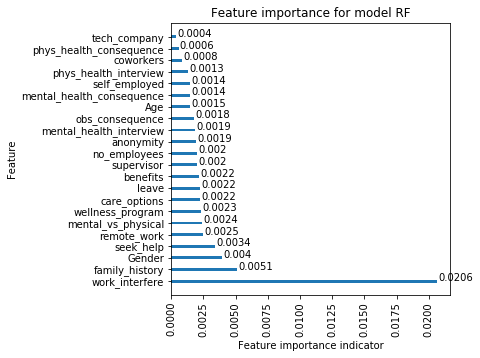

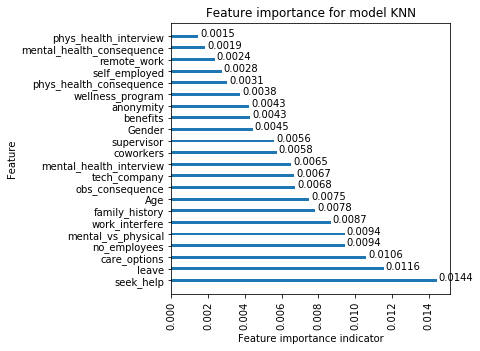

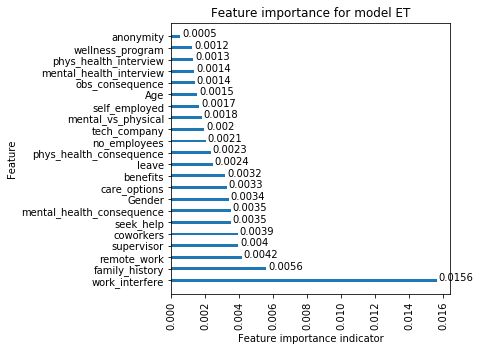

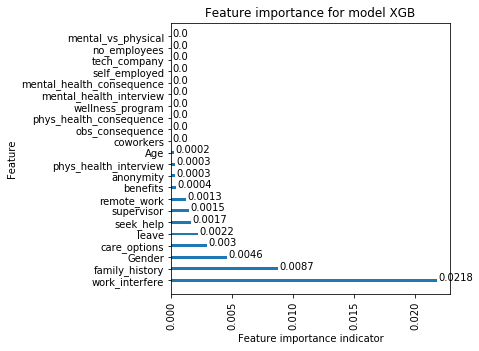

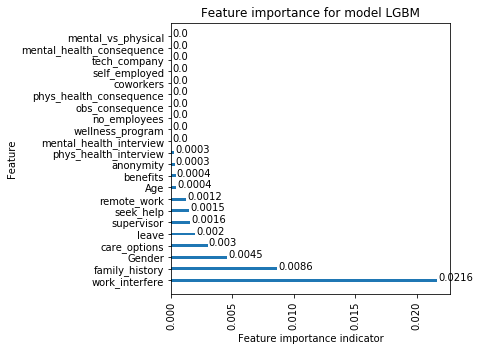

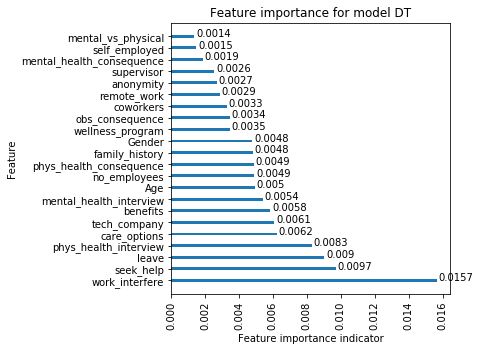

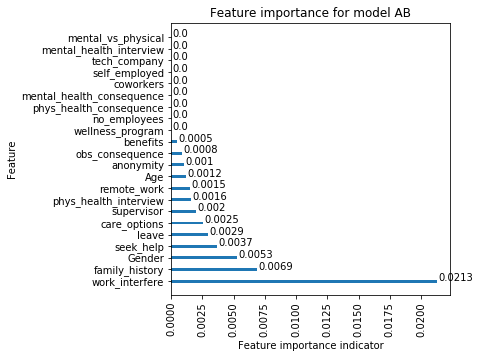

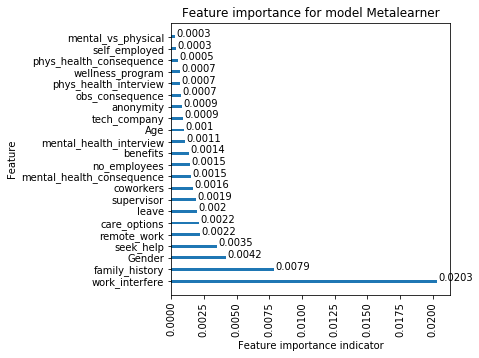

In [5]:
instability = {}
for model in ['LR','RF','KNN','ET','XGB','LGBM','DT','AB','Metalearner']:
    # Compute the features importance (standard deviation of all permutations' AUC for each feature)
    feature_importance = {}
    for feature_to_permute in features_to_permute:
        feature_importance[feature_to_permute] = AUCs[feature_to_permute][model].std()
    feature_importance = pd.DataFrame.from_dict(feature_importance,orient='index',columns=['Importance'])
    feature_importance = feature_importance.iloc[np.argsort(-feature_importance['Importance']),:]
    # Plot the features importance
    fig = plt.figure(figsize=(5,5))
    plt.barh(feature_importance.index,feature_importance['Importance'],height=0.25)
    for feature in feature_importance.index:
        importance = feature_importance.loc[feature,'Importance']
        plt.text(importance+0.0001,feature,round(importance,4)) 
    plt.xticks(rotation='vertical')
    plt.title('Feature importance for model '+str(model))
    plt.ylabel('Feature')
    plt.xlabel('Feature importance indicator')
    plt.show()
    # Compute the instability of the model (explained in next section)
    instability[model] = feature_importance['Importance'].sum(axis=0)

#### Model instability

Also, for studying the instability to data noise of the models we will create an instability indicator using the sum of all features importance indicators by models. Basically, we will sum by models the standard deviations of all permutations' AUC of all features. Then, the higher sum of standard deviations the more instability to data noise.

In [6]:
instability = pd.DataFrame.from_dict(instability,orient='index',columns=['Instability'])
instability = instability.iloc[np.argsort(-instability['Instability']).values,:]

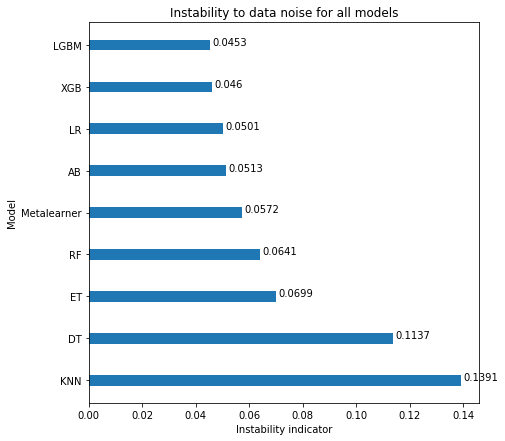

In [7]:
fig = plt.figure(figsize=(7,7))
plt.barh(instability.index,instability['Instability'],height=0.25)
for index,level in enumerate(instability.index):
    plt.text(instability['Instability'][index]+0.001,level,round(instability['Instability'][index],4))    
plt.title('Instability to data noise for all models')
plt.ylabel('Model')
plt.xlabel('Instability indicator')
plt.show()